In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [5]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [6]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [7]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [8]:
def DetailBasedNthDay(dataframe, nthday=7):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [9]:
learn_detail = DetailBasedNthDay(detail, nthday=7)

In [10]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [11]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [12]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [13]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [14]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [15]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [16]:
action = DetailBasedNthDay(engage, nthday=7)

In [17]:
action.shape

(546409, 24)

In [18]:
Recency = lambda x: 8 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek']

active.columns = cols

In [19]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [20]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [21]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [22]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [23]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 10)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [24]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 46)

In [25]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 46)

In [170]:
data = final.copy()

In [171]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [172]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [173]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [174]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [175]:
data1 = data.copy()

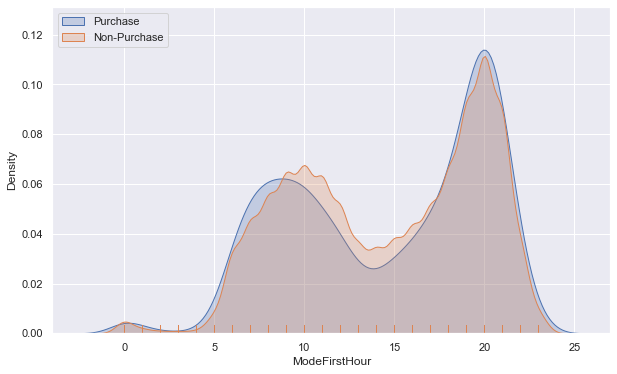

In [32]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [176]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

In [177]:
data.to_csv('ICK_Active7thdays.csv', index=False)

----- TotalUsageTime -----
count    158981.000000
mean          2.757359
std           1.361153
min           0.000000
25%           1.682688
50%           2.803360
75%           3.761898
max           7.913781
Name: TotalUsageTime, dtype: float64
* Variance: 1.8527382928709393
* Median: 2.803360380906535
* Skewness: 0.043837247191697425
* Kurtosis: -0.7390671109673845
* Percentage of outliers: 0.00015725149546172185
* Number of missing value: 0


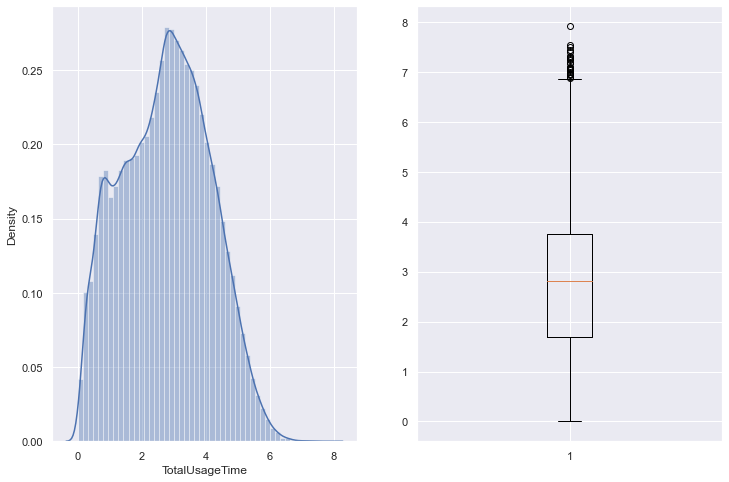


----- TotalRecords -----
count    158981.000000
mean          2.649904
std           1.383181
min           0.000000
25%           1.609438
50%           2.772589
75%           3.663562
max           7.201916
Name: TotalRecords, dtype: float64
* Variance: 1.913190503678422
* Median: 2.772588722239781
* Skewness: -0.1542631889743077
* Kurtosis: -0.6289080315460365
* Percentage of outliers: 5.0320478547750986e-05
* Number of missing value: 0


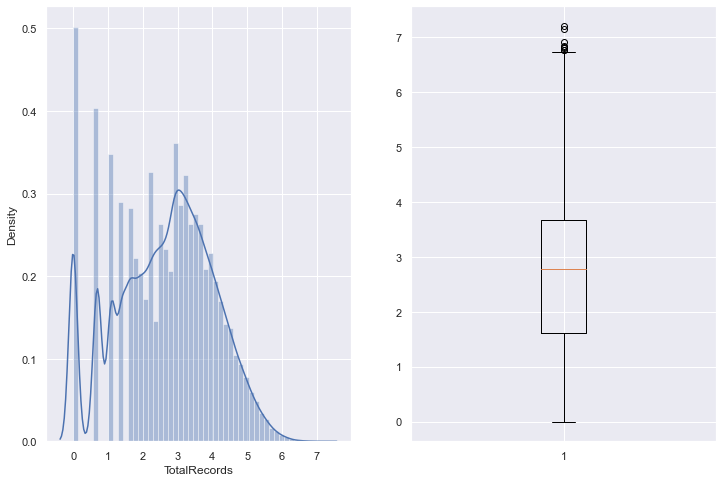


----- InteractionEnglish -----
count    158981.000000
mean          2.188795
std           2.503963
min           0.000000
25%           0.000000
50%           0.832909
75%           4.563515
max          12.818979
Name: InteractionEnglish, dtype: float64
* Variance: 6.269832795104941
* Median: 0.8329091229351039
* Skewness: 0.6868889841346603
* Kurtosis: -0.9446182684756304
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


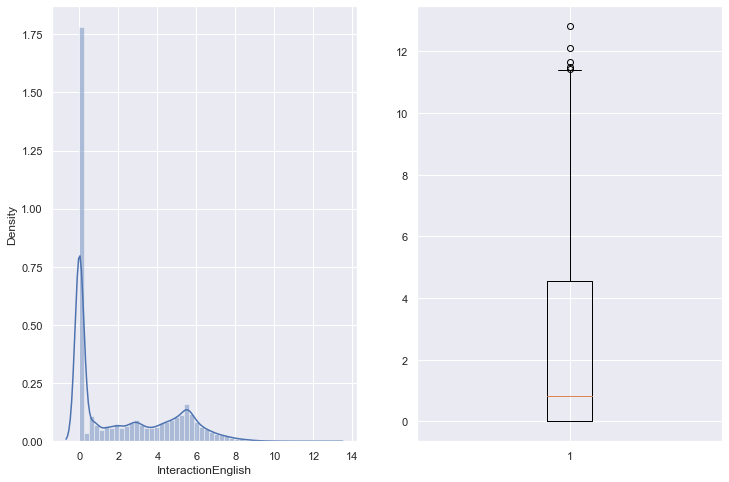


----- InteractionMath -----
count    158981.000000
mean          0.092096
std           0.661740
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.963336
Name: InteractionMath, dtype: float64
* Variance: 0.4379004453996908
* Median: 0.0
* Skewness: 8.41492026248708
* Kurtosis: 76.38732760169378
* Percentage of outliers: 0.029896654317182556
* Number of missing value: 0


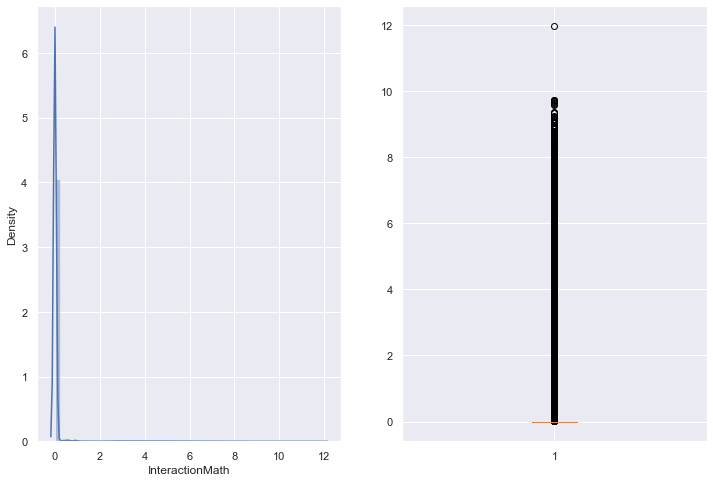


----- InteractionPhonics -----
count    158981.000000
mean          0.105643
std           0.669853
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.229654
Name: InteractionPhonics, dtype: float64
* Variance: 0.44870296697108686
* Median: 0.0
* Skewness: 7.361271763554679
* Kurtosis: 58.23207697955522
* Percentage of outliers: 0.03426824589101842
* Number of missing value: 0


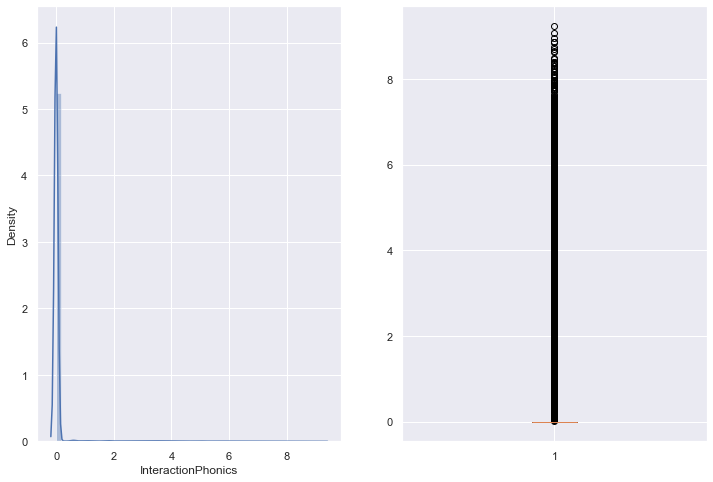


----- InteractionVietnamese -----
count    158981.000000
mean          2.327991
std           2.666926
min           0.000000
25%           0.000000
50%           0.936093
75%           4.640441
max          11.822710
Name: InteractionVietnamese, dtype: float64
* Variance: 7.1124942007354655
* Median: 0.9360933591703348
* Skewness: 0.7482482322367354
* Kurtosis: -0.8098874317864251
* Percentage of outliers: 6.290059818468873e-06
* Number of missing value: 0


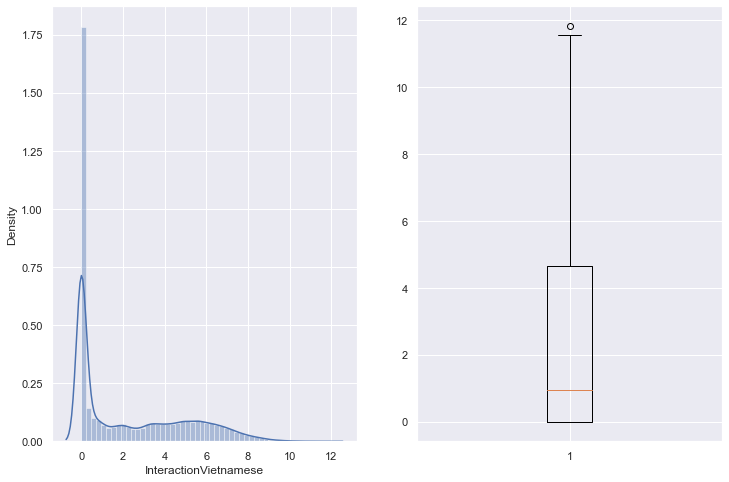


----- IsCompletedEnglish -----
count    158981.000000
mean          0.503235
std           0.534707
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           2.197225
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.28591171871216015
* Median: 0.6931471805599453
* Skewness: 0.6557950354271479
* Kurtosis: -0.48632785619820984
* Percentage of outliers: 0.0234619231228889
* Number of missing value: 0


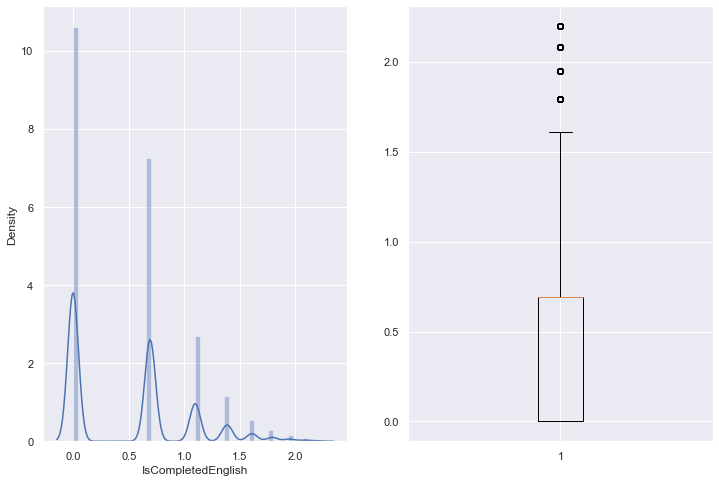


----- IsCompletedMath -----
count    158981.000000
mean          0.024902
std           0.157656
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.197225
Name: IsCompletedMath, dtype: float64
* Variance: 0.024855548330048435
* Median: 0.0
* Skewness: 7.138764228391294
* Kurtosis: 56.412502653594544
* Percentage of outliers: 0.027569332184349073
* Number of missing value: 0


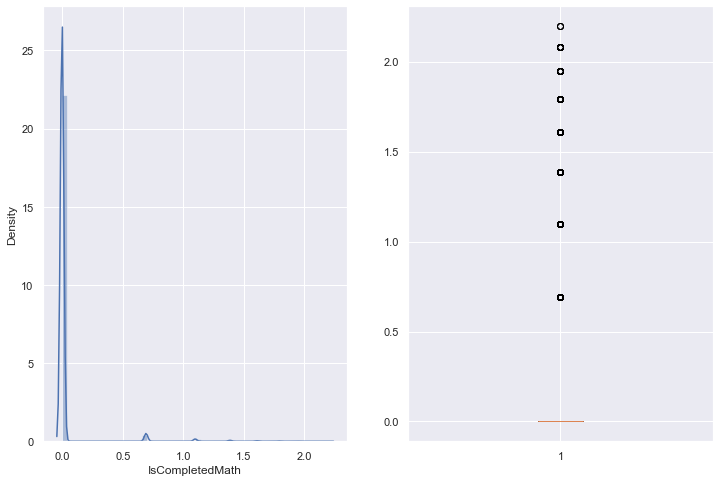


----- IsCompletedPhonics -----
count    158981.000000
mean          0.027534
std           0.161657
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.197225
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.026132995784584518
* Median: 0.0
* Skewness: 6.527026979996829
* Kurtosis: 46.81708249594512
* Percentage of outliers: 0.03146287921198131
* Number of missing value: 0


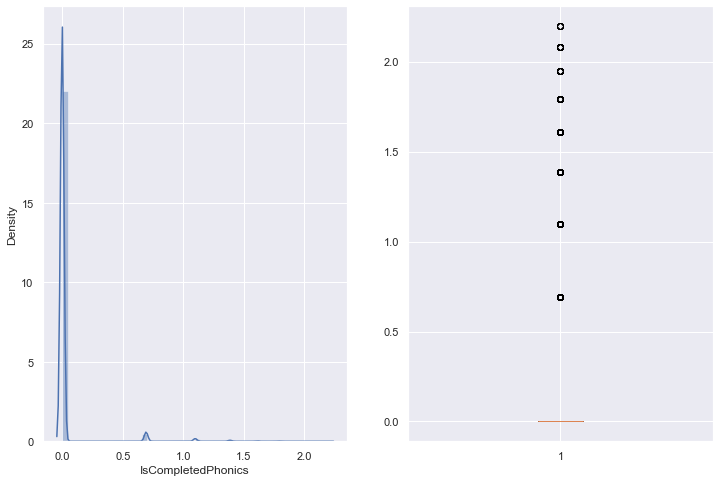


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.527101
std           0.557878
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           2.197225
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.311227473686663
* Median: 0.6931471805599453
* Skewness: 0.6959945396197253
* Kurtosis: -0.39312131391207394
* Percentage of outliers: 0.035067083487963974
* Number of missing value: 0


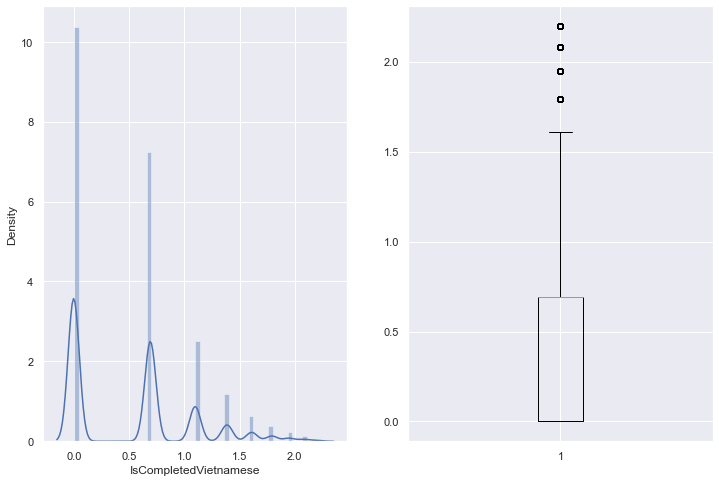


----- RecordEnglish -----
count    158981.000000
mean          1.379919
std           1.476434
min           0.000000
25%           0.000000
50%           1.098612
75%           2.772589
max           6.796824
Name: RecordEnglish, dtype: float64
* Variance: 2.179858704536131
* Median: 1.0986122886681098
* Skewness: 0.5581911636862852
* Kurtosis: -1.0168811382496175
* Percentage of outliers: 0.0
* Number of missing value: 0


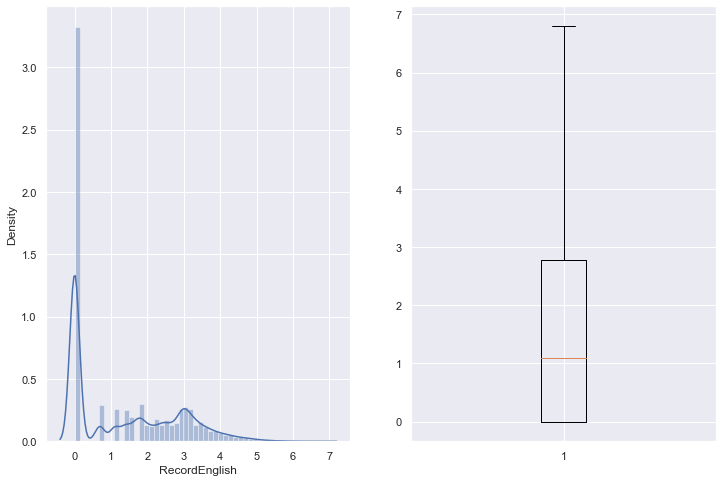


----- RecordMath -----
count    158981.000000
mean          0.060816
std           0.391446
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.799093
Name: RecordMath, dtype: float64
* Variance: 0.15323016855817717
* Median: 0.0
* Skewness: 7.433884686999475
* Kurtosis: 59.90326171592794
* Percentage of outliers: 0.029909234436819494
* Number of missing value: 0


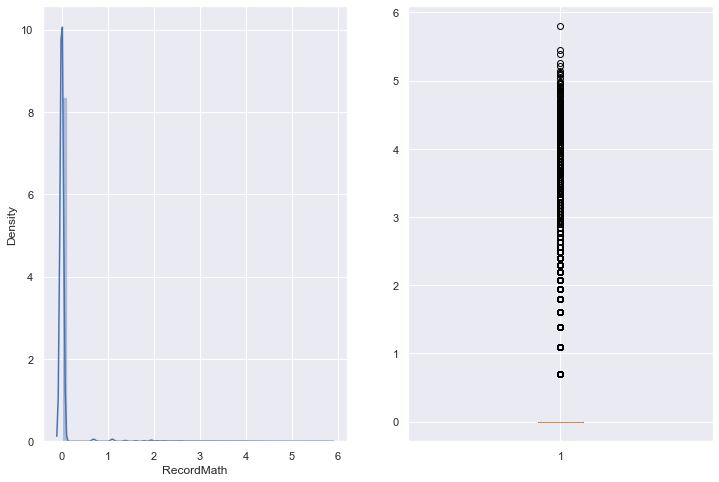


----- RecordPhonics -----
count    158981.000000
mean          0.067850
std           0.401995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.583496
Name: RecordPhonics, dtype: float64
* Variance: 0.1615997012176702
* Median: 0.0
* Skewness: 6.77548963931319
* Kurtosis: 49.598824498602184
* Percentage of outliers: 0.034293406130292296
* Number of missing value: 0


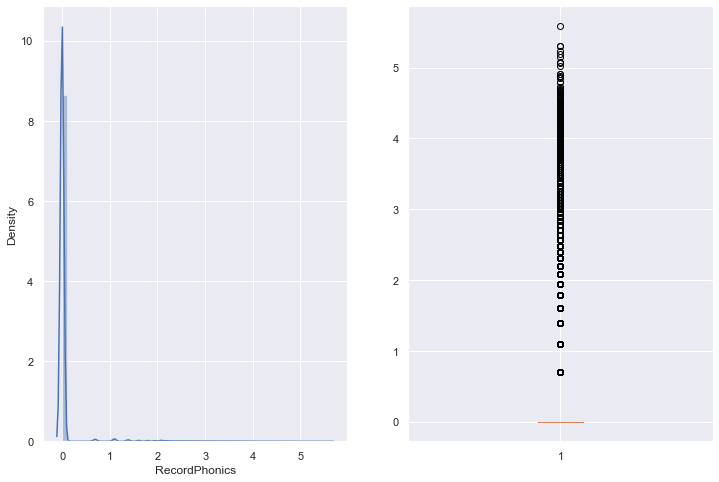


----- RecordVietnamese -----
count    158981.000000
mean          1.422731
std           1.507229
min           0.000000
25%           0.000000
50%           1.098612
75%           2.639057
max           6.775366
Name: RecordVietnamese, dtype: float64
* Variance: 2.271740445363371
* Median: 1.0986122886681098
* Skewness: 0.6729032928542354
* Kurtosis: -0.7445142730897194
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


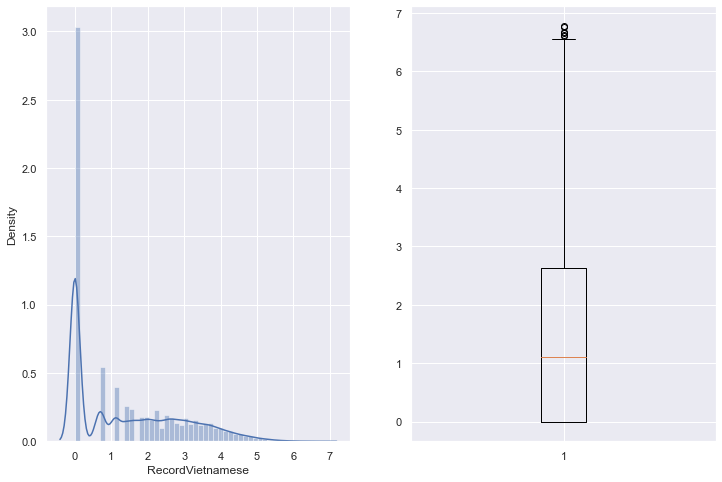


----- UsageTimeEnglish -----
count    158981.000000
mean          1.222983
std           1.364727
min           0.000000
25%           0.000000
50%           0.774727
75%           2.449279
max           7.300318
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.8624801153805692
* Median: 0.7747271675523681
* Skewness: 0.7129750701874943
* Kurtosis: -0.7007783345778957
* Percentage of outliers: 0.0001446713758247841
* Number of missing value: 0


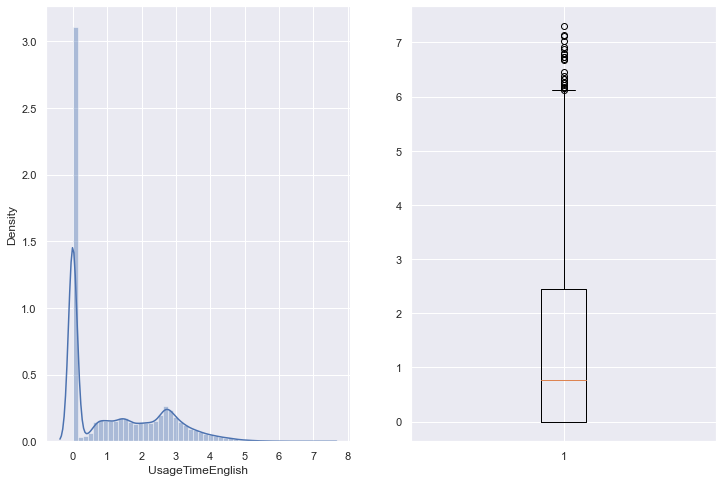


----- UsageTimeMath -----
count    158981.000000
mean          0.054318
std           0.381753
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.805149
Name: UsageTimeMath, dtype: float64
* Variance: 0.1457352212167786
* Median: 0.0
* Skewness: 8.449541865690563
* Kurtosis: 78.63084417632172
* Percentage of outliers: 0.029896654317182556
* Number of missing value: 0


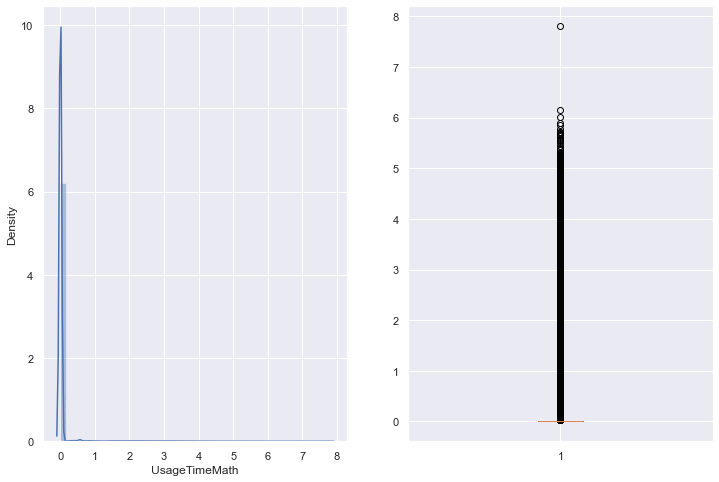


----- UsageTimePhonics -----
count    158981.000000
mean          0.065343
std           0.395036
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.405152
Name: UsageTimePhonics, dtype: float64
* Variance: 0.15605369961054325
* Median: 0.0
* Skewness: 6.9346591469631695
* Kurtosis: 51.983645422233735
* Percentage of outliers: 0.03426824589101842
* Number of missing value: 0


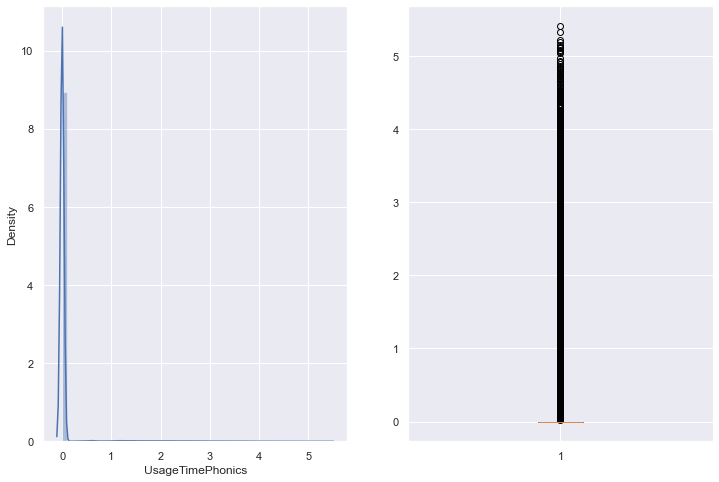


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.338870
std           1.476603
min           0.000000
25%           0.000000
50%           0.788457
75%           2.563410
max           6.742881
Name: UsageTimeVietnamese, dtype: float64
* Variance: 2.1803560499928145
* Median: 0.7884573603642703
* Skewness: 0.7228735253387257
* Kurtosis: -0.720529575547717
* Percentage of outliers: 5.6610538366219865e-05
* Number of missing value: 0


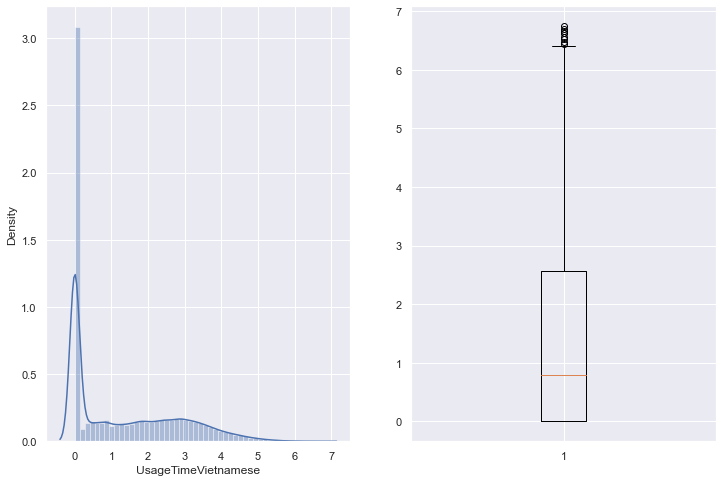


----- RecordDiscovery -----
count    158981.000000
mean          0.690749
std           0.944810
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max           5.327876
Name: RecordDiscovery, dtype: float64
* Variance: 0.8926654900358599
* Median: 0.0
* Skewness: 1.1491986795314935
* Kurtosis: 0.20298400582359877
* Percentage of outliers: 0.006082487844459401
* Number of missing value: 0


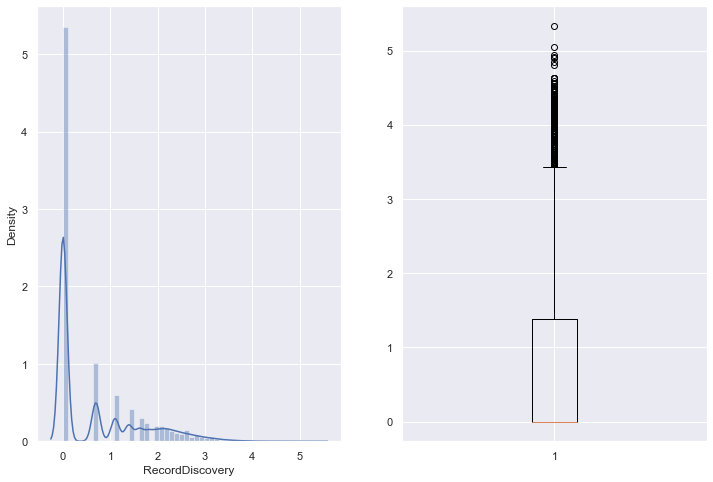


----- RecordEntertainment -----
count    158981.000000
mean          0.836962
std           1.128263
min           0.000000
25%           0.000000
50%           0.000000
75%           1.609438
max           6.570883
Name: RecordEntertainment, dtype: float64
* Variance: 1.2729765951603935
* Median: 0.0
* Skewness: 1.2119030973757323
* Kurtosis: 0.5613975436937215
* Percentage of outliers: 0.011435328749976412
* Number of missing value: 0


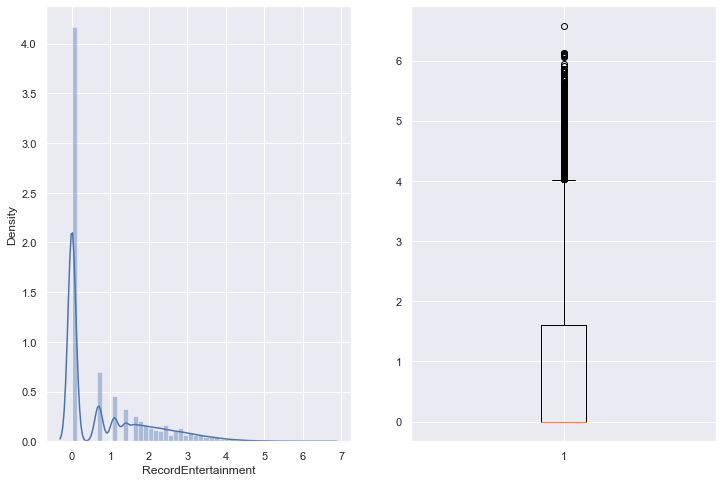


----- RecordLearn -----
count    158981.000000
mean          2.489259
std           1.291008
min           0.000000
25%           1.386294
50%           2.564949
75%           3.401197
max           7.107425
Name: RecordLearn, dtype: float64
* Variance: 1.666702105614368
* Median: 2.5649493574615367
* Skewness: 0.01851302014371947
* Kurtosis: -0.607235998757802
* Percentage of outliers: 0.0001698316150986596
* Number of missing value: 0


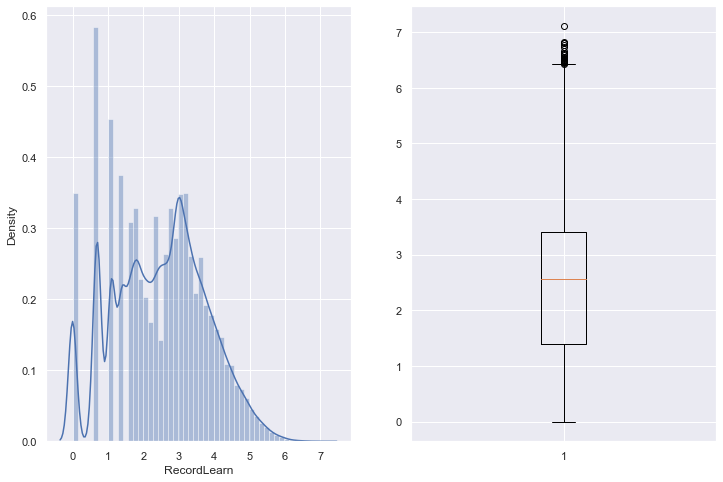


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.893178
std           1.261525
min           0.000000
25%           0.000000
50%           0.000000
75%           1.835776
max           6.344109
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.5914448797719107
* Median: 0.0
* Skewness: 1.089116120167318
* Kurtosis: -0.19763917160332145
* Percentage of outliers: 0.0022832917141042013
* Number of missing value: 0


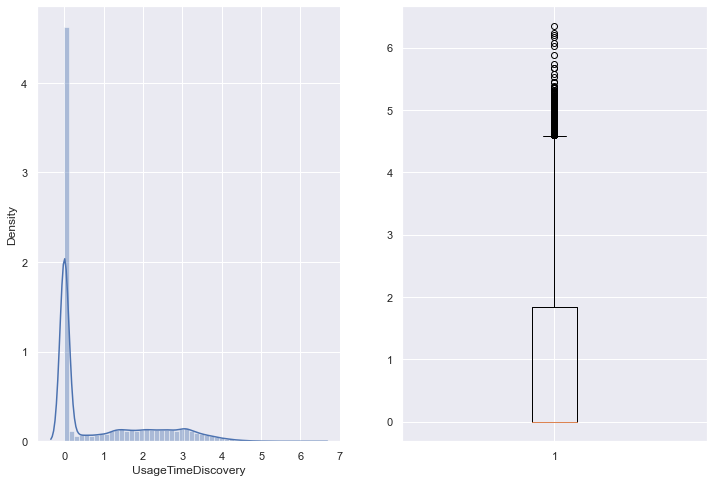


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.941360
std           1.383669
min           0.000000
25%           0.000000
50%           0.000000
75%           1.745716
max           7.271043
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.9145388868206294
* Median: 0.0
* Skewness: 1.3453825528634726
* Kurtosis: 0.7046557886937332
* Percentage of outliers: 0.026713884049037306
* Number of missing value: 0


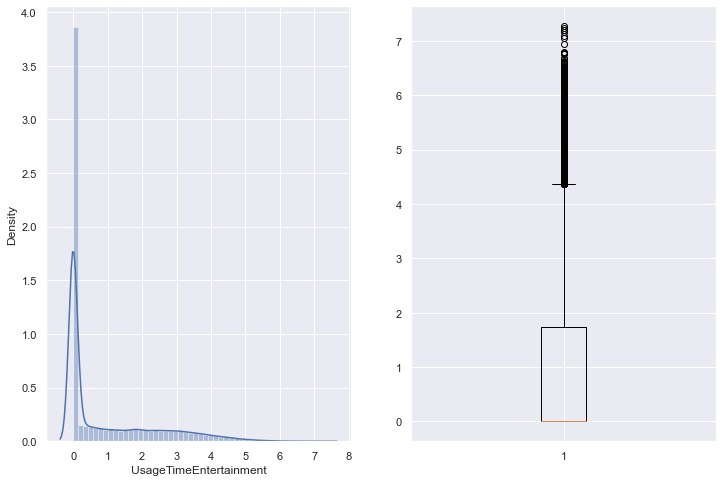


----- UsageTimeLearn -----
count    158981.000000
mean          2.294030
std           1.299959
min           0.000000
25%           1.258461
50%           2.374906
75%           3.218076
max           7.825808
Name: UsageTimeLearn, dtype: float64
* Variance: 1.6898935110698439
* Median: 2.3749057545736716
* Skewness: 0.0871132462819519
* Kurtosis: -0.6622181748706399
* Percentage of outliers: 0.00039627376856353903
* Number of missing value: 0


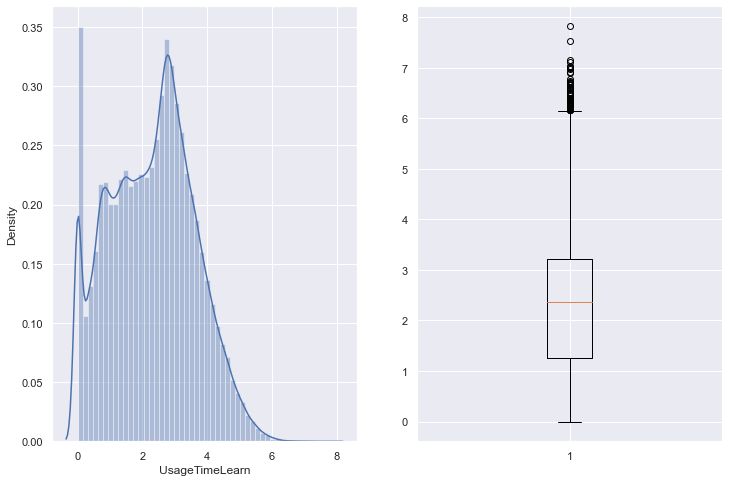


----- MedianUsageTime -----
count    158981.000000
mean          1.830593
std           0.806490
min           0.000000
25%           1.236924
50%           1.868721
75%           2.424803
max           5.357435
Name: MedianUsageTime, dtype: float64
* Variance: 0.6504263183961965
* Median: 1.8687205103641833
* Skewness: -0.03058218048691549
* Kurtosis: -0.5638118346936829
* Percentage of outliers: 0.0010064095709550198
* Number of missing value: 0


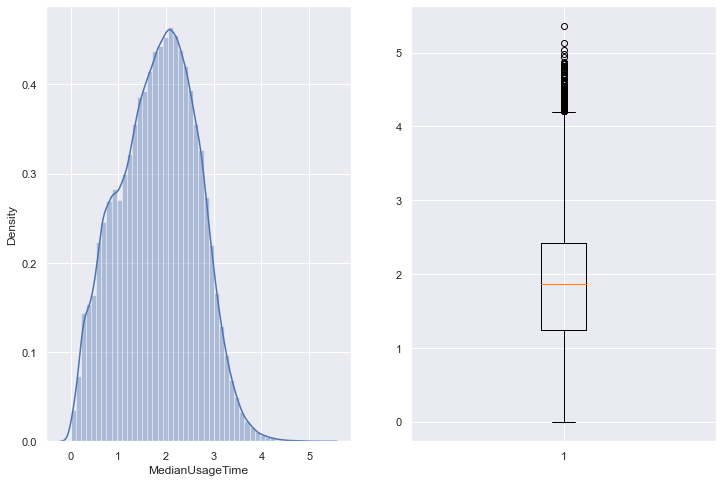


----- MedianRecord -----
count    158981.000000
mean          1.593661
std           0.898381
min           0.000000
25%           1.098612
50%           1.609438
75%           2.251292
max           5.231109
Name: MedianRecord, dtype: float64
* Variance: 0.8070886183582321
* Median: 1.6094379124341003
* Skewness: -0.024468856673662574
* Kurtosis: -0.5429497731281989
* Percentage of outliers: 0.001792667048263629
* Number of missing value: 0


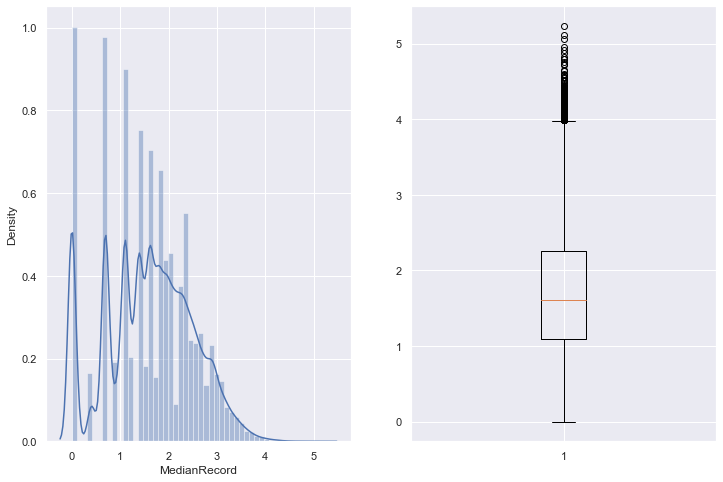


----- MedianPaymentScreen -----
count    158981.000000
mean          0.445553
std           0.646540
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.4180136926563552
* Median: 0.0
* Skewness: 1.4561825292939552
* Kurtosis: 1.7606962178524959
* Percentage of outliers: 0.055088343890150396
* Number of missing value: 0


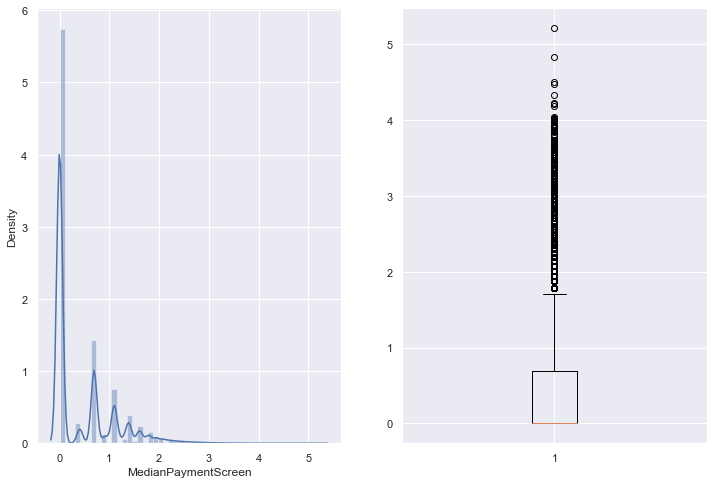


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.683880
std           0.255322
min           0.000000
25%           0.528420
50%           0.642292
75%           0.807963
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06518952057716303
* Median: 0.6422923865082963
* Skewness: 1.082507813715625
* Kurtosis: 3.2338976369687393
* Percentage of outliers: 0.04011171146237601
* Number of missing value: 0


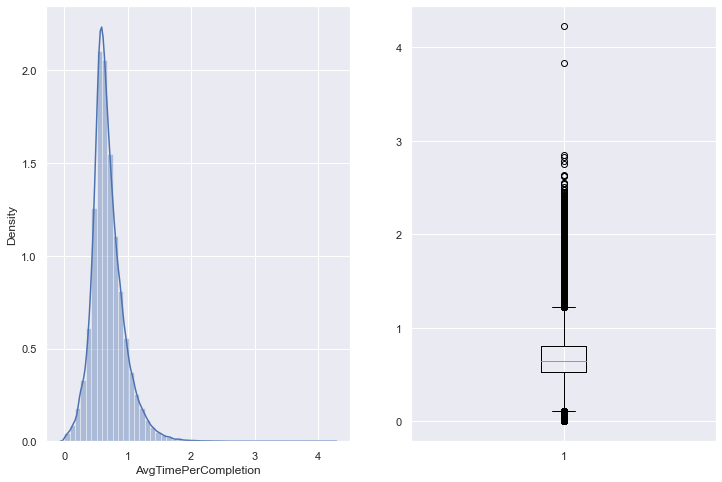


----- InteractionGeneral -----
count    158981.000000
mean          5.325180
std           2.767457
min           0.000000
25%           3.171784
50%           5.541577
75%           7.378246
max          14.577391
Name: InteractionGeneral, dtype: float64
* Variance: 7.658819220905711
* Median: 5.541577221447071
* Skewness: -0.041837383922923146
* Kurtosis: -0.7776791380072421
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


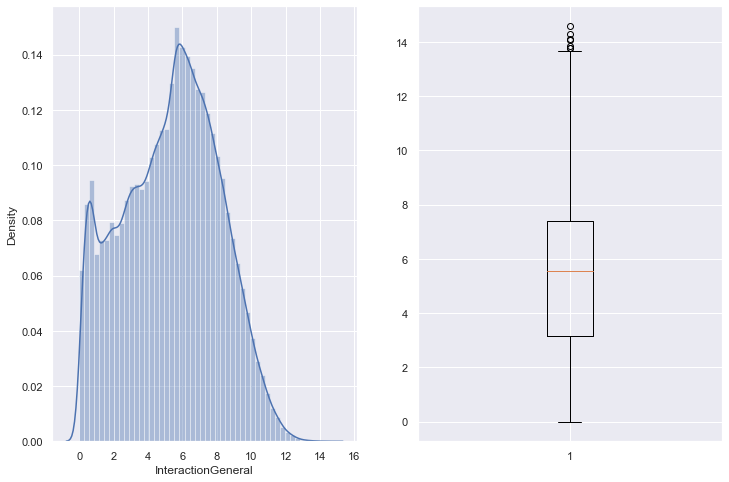


----- InteractionLearn -----
count    158981.000000
mean          4.537618
std           2.745583
min           0.000000
25%           2.274186
50%           4.755055
75%           6.529579
max          14.259813
Name: InteractionLearn, dtype: float64
* Variance: 7.538228304603851
* Median: 4.755054635525384
* Skewness: 0.055044457592826425
* Kurtosis: -0.8170058474663611
* Percentage of outliers: 0.0001446713758247841
* Number of missing value: 0


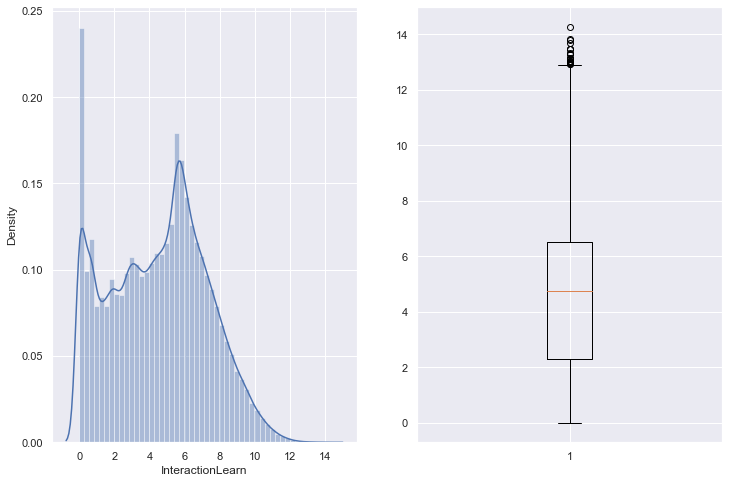


----- InteractionDiscovery -----
count    158981.000000
mean          1.412904
std           2.120631
min           0.000000
25%           0.000000
50%           0.000000
75%           2.653242
max          11.283402
Name: InteractionDiscovery, dtype: float64
* Variance: 4.497076846834528
* Median: 0.0
* Skewness: 1.3066933741421318
* Kurtosis: 0.4484819003433853
* Percentage of outliers: 0.023216610789968613
* Number of missing value: 0


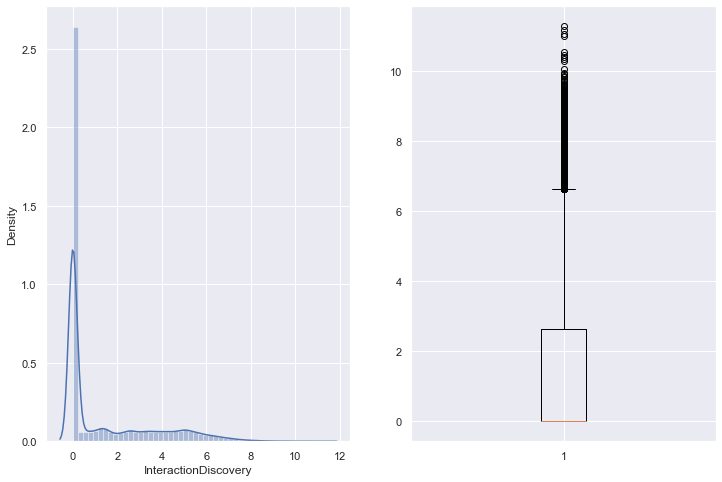


----- InteractionEntertainment -----
count    158981.000000
mean          1.602720
std           2.436498
min           0.000000
25%           0.000000
50%           0.000000
75%           2.870736
max          13.341087
Name: InteractionEntertainment, dtype: float64
* Variance: 5.936524102879324
* Median: 0.0
* Skewness: 1.4415360138936495
* Kurtosis: 1.0421208371288206
* Percentage of outliers: 0.04111183097351256
* Number of missing value: 0


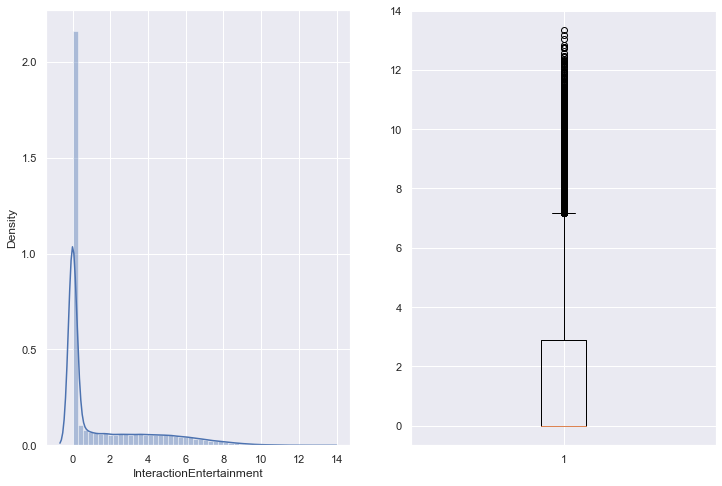


----- MedianInteraction -----
count    158981.000000
mean          3.300927
std           1.668553
min           0.000000
25%           2.036012
50%           3.356200
75%           4.521789
max          10.043499
Name: MedianInteraction, dtype: float64
* Variance: 2.7840704573520467
* Median: 3.3562000157314196
* Skewness: 0.03937450367736882
* Kurtosis: -0.6474891338686781
* Percentage of outliers: 0.0007170668193054516
* Number of missing value: 0


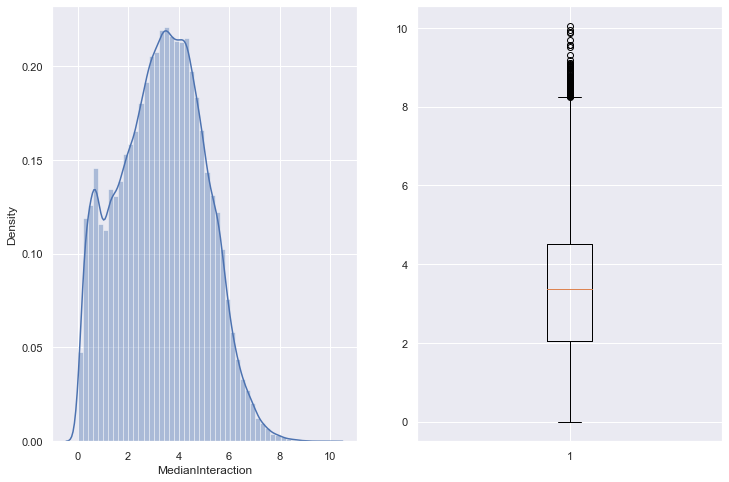

In [34]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  TotalChild                158981 non-null  float64
 11  MedianChildAge            158981 non-null  float64
 12  No.Female                 158981 non-null  float64
 13  No.Male                   158981 non-null  f

In [36]:
data

,UserID,Recency,ContentFrequent,PaymentScreenFrequent,TotalUsageTime,TotalRecords,ModeFirstHour,ModeLastHour,ModeLastDay,ModeDayofweek,...,firstPaymentType,JoinMonth,gapday,AvgTimePerCompletion,InteractionGeneral,InteractionLearn,InteractionDiscovery,InteractionEntertainment,MedianInteraction,Label
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,8,1,0,2.927453,2.890372,22,22,11,0,...,NaN,7.0,NaN,0.684219,5.765943,5.765943,0.000000,0.00000,5.765943,0
1,00007f9f-be36-4a0d-a2a8-167231588625,8,1,0,2.060514,1.098612,18,18,12,1,...,NaN,4.0,NaN,1.188859,3.070376,0.000000,3.070376,0.00000,3.070376,0
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,2,14,79,5.346869,5.298317,18,20,18,0,...,NaN,4.0,NaN,0.715276,10.640436,8.902477,8.296547,7.94930,4.155753,0
3,0001f256-edcf-4980-b84b-85d85745fd0f,7,3,0,3.774139,4.110874,8,20,22,4,...,NaN,7.0,NaN,0.529277,7.862174,7.830744,0.488580,0.00000,5.845108,0
4,000234a9-a233-4476-9023-9b83f331b7f6,8,2,0,2.746630,3.295837,18,18,16,6,...,NaN,4.0,NaN,0.432023,5.978709,5.922436,0.239017,0.00000,4.599982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,8,1,0,0.392042,0.000000,21,21,13,0,...,NaN,6.0,NaN,0.392042,0.392042,0.392042,0.000000,0.00000,0.392042,0
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,8,1,1,1.613430,1.609438,20,21,12,6,...,NaN,6.0,NaN,0.590006,3.049273,3.049273,0.000000,0.00000,3.049273,0
163037,ffff56de-effe-4b67-9990-33240f51c866,8,2,2,1.418277,1.791759,20,20,3,6,...,NaN,7.0,NaN,0.419806,2.984671,2.656757,0.392042,0.00000,1.739589,0
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1,5,0,4.007515,3.433987,12,12,24,4,...,NaN,6.0,NaN,1.008782,7.423754,2.132982,4.663439,6.61962,2.415914,0


In [37]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [40]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [41]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [42]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9460545351616556

In [43]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9461

* Confusion Matrix: 
[[29546   191]
 [ 1522   538]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.74      0.26      0.39      2060

    accuracy                           0.95     31797
   macro avg       0.84      0.63      0.68     31797
weighted avg       0.94      0.95      0.93     31797



In [44]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9476034721348597

In [45]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9478

* Confusion Matrix: 
[[29557   180]
 [ 1481   579]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.76      0.28      0.41      2060

    accuracy                           0.95     31797
   macro avg       0.86      0.64      0.69     31797
weighted avg       0.94      0.95      0.94     31797



In [112]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=6,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9320905145301296

In [113]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9254

* Confusion Matrix: 
[[28122  1615]
 [  758  1302]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.45      0.63      0.52      2060

    accuracy                           0.93     31797
   macro avg       0.71      0.79      0.74     31797
weighted avg       0.94      0.93      0.93     31797



In [116]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9672757579569757

In [117]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9408

* Confusion Matrix: 
[[28726  1011]
 [  871  1189]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.58      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.77      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7716


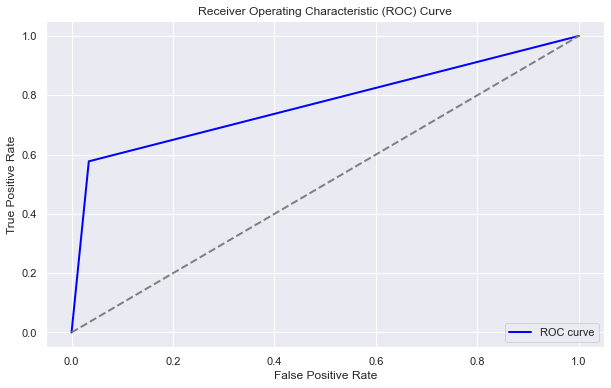

In [53]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test)) 

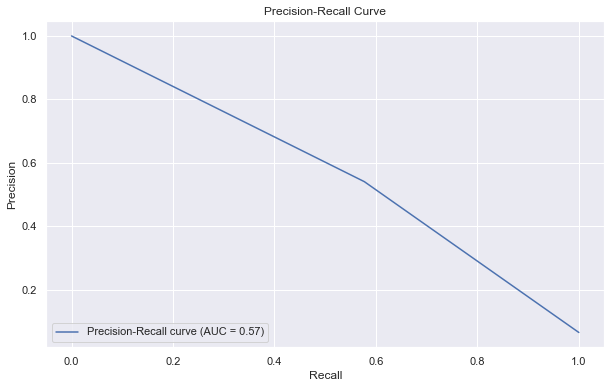

In [54]:
fc.plot_precision_recall_curve(lgbm_model, X_test, y_test)

In [95]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9318389105547867

In [96]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.924

* Confusion Matrix: 
[[28062  1675]
 [  740  1320]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     29737
           1       0.44      0.64      0.52      2060

    accuracy                           0.92     31797
   macro avg       0.71      0.79      0.74     31797
weighted avg       0.94      0.92      0.93     31797



ROC AUC score: 0.7922


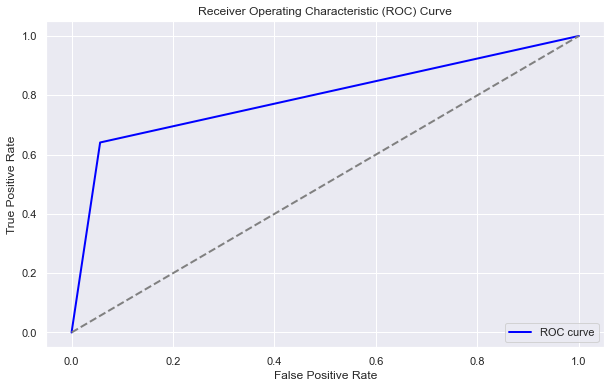

In [97]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [79]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9724729525726507

In [80]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.94

* Confusion Matrix: 
[[28695  1042]
 [  865  1195]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.53      0.58      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.75      0.77      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7725


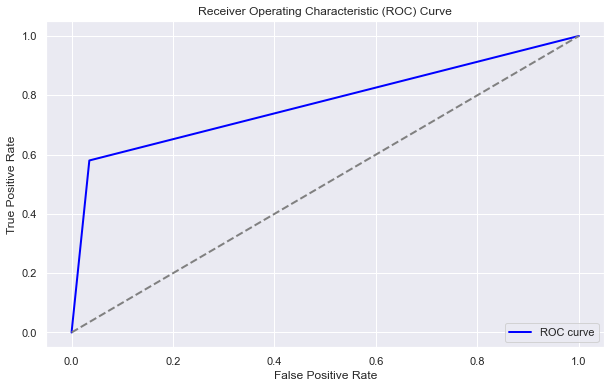

In [82]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [91]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9457557554409359

In [94]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9407

* Confusion Matrix: 
[[28704  1033]
 [  851  1209]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.59      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.78      0.77     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7761


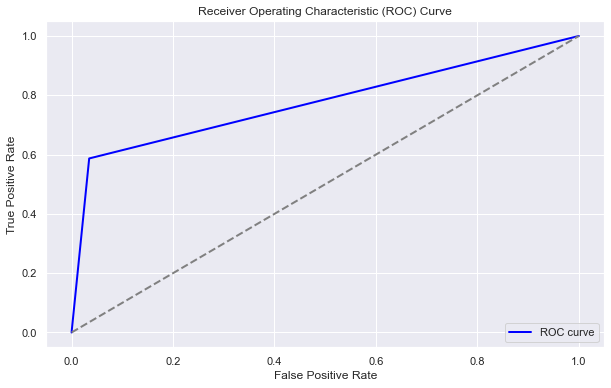

In [93]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [98]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9667804126305196

In [99]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9408

* Confusion Matrix: 
[[28736  1001]
 [  882  1178]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.57      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.77      0.76     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7691


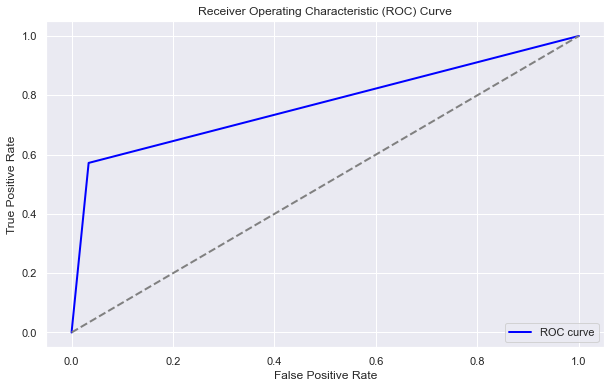

In [100]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [101]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8745596930431501

In [102]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8679

* Confusion Matrix: 
[[26050  3687]
 [  513  1547]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     29737
           1       0.30      0.75      0.42      2060

    accuracy                           0.87     31797
   macro avg       0.64      0.81      0.67     31797
weighted avg       0.94      0.87      0.89     31797



ROC AUC score: 0.8135


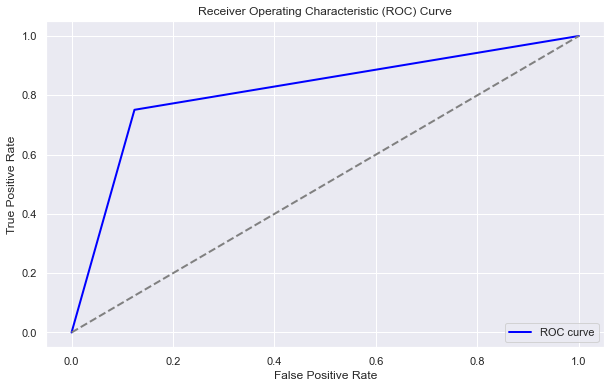

In [103]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [124]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8706441061768776

In [125]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8637

* Confusion Matrix: 
[[25899  3838]
 [  497  1563]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     29737
           1       0.29      0.76      0.42      2060

    accuracy                           0.86     31797
   macro avg       0.64      0.81      0.67     31797
weighted avg       0.94      0.86      0.89     31797



ROC AUC score: 0.8148


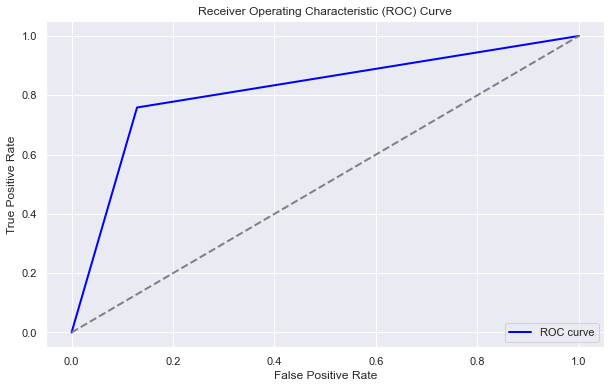

In [126]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [127]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.8173355139011197

In [128]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8165

* Confusion Matrix: 
[[24594  5143]
 [  691  1369]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     29737
           1       0.21      0.66      0.32      2060

    accuracy                           0.82     31797
   macro avg       0.59      0.75      0.61     31797
weighted avg       0.92      0.82      0.86     31797



In [129]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [130]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9164

* Confusion Matrix: 
[[28299  1438]
 [ 1219   841]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.37      0.41      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.68      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [131]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8103849540822745

In [132]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8107

* Confusion Matrix: 
[[24229  5508]
 [  512  1548]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     29737
           1       0.22      0.75      0.34      2060

    accuracy                           0.81     31797
   macro avg       0.60      0.78      0.61     31797
weighted avg       0.93      0.81      0.85     31797



In [133]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.812720153478425

In [134]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8119

* Confusion Matrix: 
[[24268  5469]
 [  512  1548]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     29737
           1       0.22      0.75      0.34      2060

    accuracy                           0.81     31797
   macro avg       0.60      0.78      0.62     31797
weighted avg       0.93      0.81      0.85     31797



In [135]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9251949930808907

In [136]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9241

* Confusion Matrix: 
[[28311  1426]
 [  987  1073]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.43      0.52      0.47      2060

    accuracy                           0.92     31797
   macro avg       0.70      0.74      0.71     31797
weighted avg       0.93      0.92      0.93     31797



In [137]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8694804377909171

In [138]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8696

* Confusion Matrix: 
[[26255  3482]
 [  663  1397]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     29737
           1       0.29      0.68      0.40      2060

    accuracy                           0.87     31797
   macro avg       0.63      0.78      0.66     31797
weighted avg       0.93      0.87      0.89     31797



In [139]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [140]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9207

* Confusion Matrix: 
[[28482  1255]
 [ 1268   792]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.39      0.38      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [141]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [142]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9212

* Confusion Matrix: 
[[28495  1242]
 [ 1265   795]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.39      0.39      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [143]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [144]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9202

* Confusion Matrix: 
[[28448  1289]
 [ 1248   812]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.39      0.39      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.68      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [145]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [146]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9206

* Confusion Matrix: 
[[28468  1269]
 [ 1256   804]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.39      0.39      0.39      2060

    accuracy                           0.92     31797
   macro avg       0.67      0.67      0.67     31797
weighted avg       0.92      0.92      0.92     31797



In [147]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [148]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.953

* Confusion Matrix: 
[[29585   152]
 [ 1343   717]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29737
           1       0.83      0.35      0.49      2060

    accuracy                           0.95     31797
   macro avg       0.89      0.67      0.73     31797
weighted avg       0.95      0.95      0.94     31797



In [149]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999606868788526

In [150]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9534

* Confusion Matrix: 
[[29629   108]
 [ 1374   686]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     29737
           1       0.86      0.33      0.48      2060

    accuracy                           0.95     31797
   macro avg       0.91      0.66      0.73     31797
weighted avg       0.95      0.95      0.94     31797



In [151]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9471002641841741

In [152]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9414

* Confusion Matrix: 
[[28738   999]
 [  865  1195]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.58      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.77      0.77     31797
weighted avg       0.94      0.94      0.94     31797



In [169]:
data.to_csv('ICK_Active7thdays.csv', index=False)

In [154]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [155]:
class_weights_dict = dict(enumerate(class_weights))

In [156]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [157]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8704868536922883

In [158]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8662

* Confusion Matrix: 
[[25990  3747]
 [  507  1553]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     29737
           1       0.29      0.75      0.42      2060

    accuracy                           0.87     31797
   macro avg       0.64      0.81      0.67     31797
weighted avg       0.94      0.87      0.89     31797



In [159]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9672993458296641

In [160]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.954

* Confusion Matrix: 
[[29502   235]
 [ 1228   832]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     29737
           1       0.78      0.40      0.53      2060

    accuracy                           0.95     31797
   macro avg       0.87      0.70      0.75     31797
weighted avg       0.95      0.95      0.95     31797



In [161]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9473125550383696

In [162]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9342

* Confusion Matrix: 
[[28466  1271]
 [  821  1239]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     29737
           1       0.49      0.60      0.54      2060

    accuracy                           0.93     31797
   macro avg       0.73      0.78      0.75     31797
weighted avg       0.94      0.93      0.94     31797



In [163]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [164]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9959602838310465

In [165]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9925

* Confusion Matrix: 
[[118227    717]
 [   243   7997]]

* Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    118944
           1       0.92      0.97      0.94      8240

    accuracy                           0.99    127184
   macro avg       0.96      0.98      0.97    127184
weighted avg       0.99      0.99      0.99    127184



In [166]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9455

* Confusion Matrix: 
[[28987   750]
 [  983  1077]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.59      0.52      0.55      2060

    accuracy                           0.95     31797
   macro avg       0.78      0.75      0.76     31797
weighted avg       0.94      0.95      0.94     31797



In [167]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9553151062684961

In [168]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9153

* Confusion Matrix: 
[[27743  1994]
 [  700  1360]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     29737
           1       0.41      0.66      0.50      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.80      0.73     31797
weighted avg       0.94      0.92      0.92     31797



In [178]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9457557554409359

In [179]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9407

* Confusion Matrix: 
[[28704  1033]
 [  851  1209]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.54      0.59      0.56      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.78      0.77     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7761


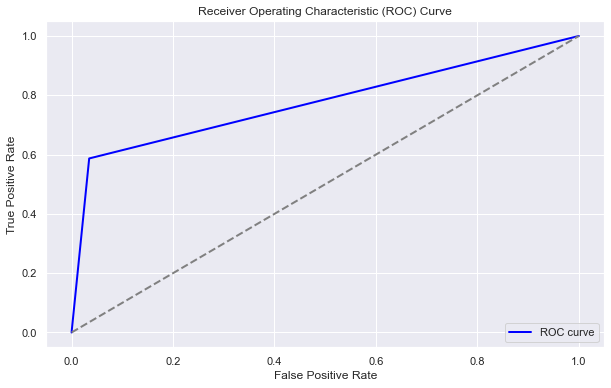

In [181]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [180]:
display_df = ft.eval_clf_model_on_features(lgbm_model, X_train, y_train, X_test, y_test)
display_df.index = ['All features']
display_df

,Accuracy,ROC,Precision,Recall,F1-score,Feature Count
All features,0.940749,0.776078,0.539251,0.586893,0.562064,49


In [183]:
rfe_ft = ft.run_rfe(lgbm_model, X_train, y_train, 45)
rfe_df = ft.eval_clf_model_on_features(lgbm_model, X_train[rfe_ft], y_train, X_test[rfe_ft], y_test)
rfe_df.index = ['F-test']

display_df = display_df.append(rfe_df)
display_df

,Accuracy,ROC,Precision,Recall,F1-score,Feature Count
All features,0.940749,0.776078,0.539251,0.586893,0.562064,49
F-test,0.940372,0.773617,0.536705,0.582039,0.558454,46
F-test,0.940906,0.775258,0.540601,0.584951,0.561903,45


In [184]:
sum(y_train == 0) / sum(y_train == 1)

14.43495145631068

In [189]:
sw_isns

array([0.0029, 0.011 ])